In [79]:
import numpy as np
from matplotlib import pyplot as plt
dt = 0.1 
T = 10 
omega = 1
acc_z = 1 + 9.81 
acc_x = 1.0

time = np.arange(0, T + dt, dt)
angular_velocity = np.zeros((len(time), 3))
angular_velocity[:, 2] = omega
orientation = np.zeros((len(time), 3))
orientation[:, 2] = omega * time
delta_orientation = np.zeros((len(time), 3))
delta_orientation[:, 2] = omega * dt 

filtered_acceleration = np.zeros((len(time), 3))
filtered_acceleration[:, 2] = acc_z
filtered_acceleration[:, 0] = acc_x
acceleration = filtered_acceleration
gravity_world = np.array([0, 0, -9.81])  

In [80]:
def rotation_matrix(roll, pitch, yaw):
    c_yaw, s_yaw = np.cos(yaw), np.sin(yaw)  
    c_pitch, s_pitch = np.cos(pitch), np.sin(pitch)  
    c_roll, s_roll = np.cos(roll), np.sin(roll)  
    
    R = np.array([
        [c_yaw * c_pitch, c_yaw * s_pitch * s_roll - s_yaw * c_roll, c_yaw * s_pitch * c_roll + s_yaw * s_roll],
        [s_yaw * c_pitch, s_yaw * s_pitch * s_roll + c_yaw * c_roll, s_yaw * s_pitch * c_roll - c_yaw * s_roll],
        [-s_pitch, c_pitch * s_roll, c_pitch * c_roll]
    ])
    
    return R

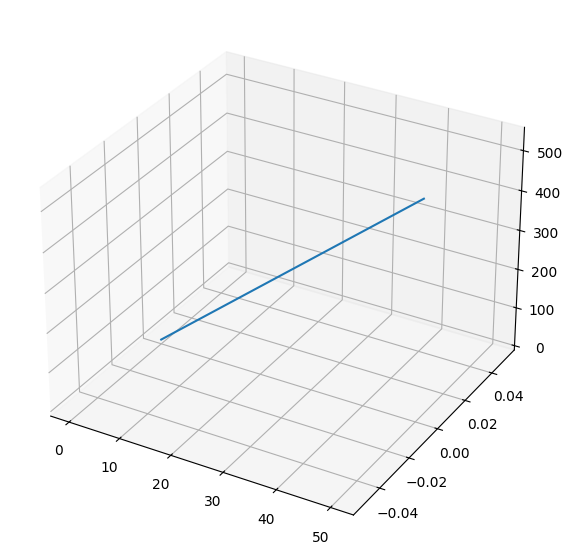

In [81]:
t_prev = time[0]
total_rotation = np.eye(3)  
gravity_world = np.array([0, 0, -9.81])
vel_prev = filtered_acceleration[0] * time[0]
position = [vel_prev*time[0]]
t_prev = 0
for t, ac in zip(time[1:], filtered_acceleration[1:]):
    dt = t - t_prev
    vel = vel_prev + ac*dt 
    position.append(position[-1] + vel*dt)
    vel_prev = vel
    t_prev = t
    
position = np.array(position)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
# Plot the trajectory
ax.plot(position[:,0], position[:,1], position[:,2], label="Trajectory")
total_rotation = [np.eye(3)]
for t, delta in zip(time, delta_orientation):
    total_rotation.append(rotation_matrix(*delta) @ total_rotation[-1])


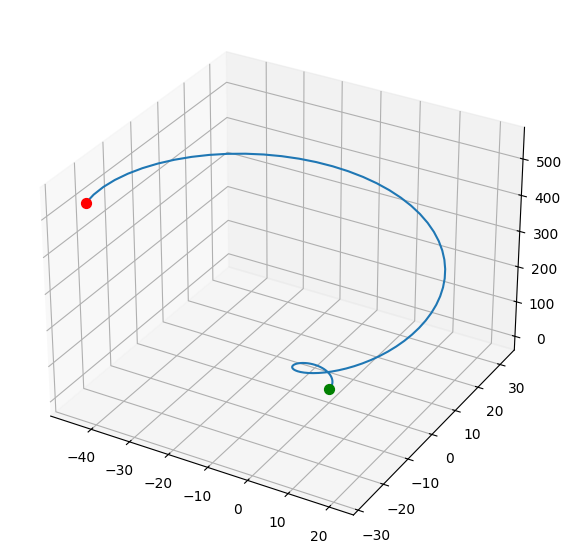

In [82]:
trajectory = []
for a,(pos, rot) in enumerate(zip(position, total_rotation)):
    new_pos_world = rot @ pos
    trajectory.append(new_pos_world)

trajectory = np.array(trajectory)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
# Plot the trajectory
ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2], label="Trajectory") 
ax.scatter(trajectory[0,0], trajectory[0,1], trajectory[0,2], color="green", label="Start", s=50)  # Start point
ax.scatter(trajectory[-1,0], trajectory[-1,1], trajectory[-1,2], color="red", label="End", s=50)  # End point

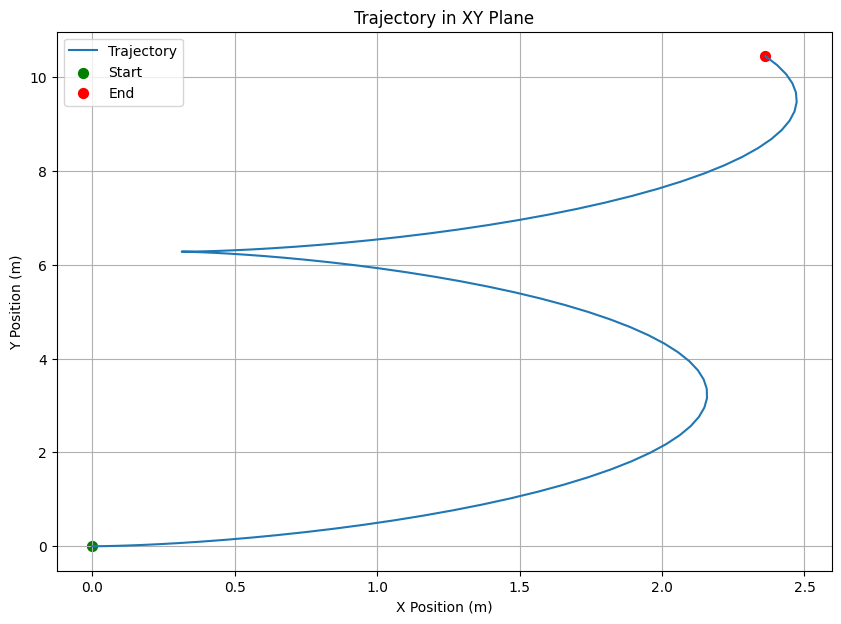

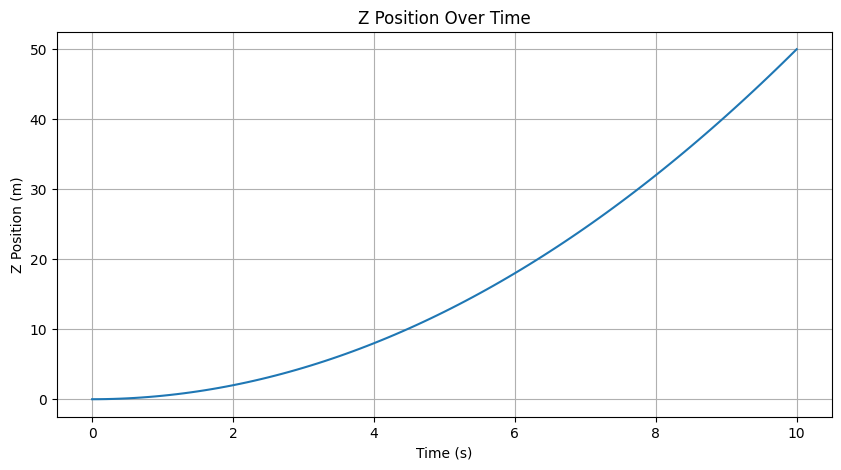

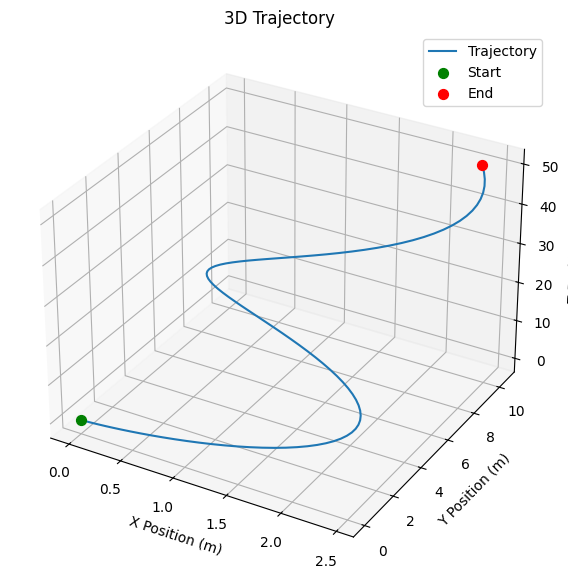

In [83]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# Initialize orientation (identity quaternion)
orientations = [R.identity()]

# Update orientations using gyroscope data
for i in range(1, len(time)):
    omega_vec = angular_velocity[i] * dt  # Angular displacement vector
    delta_rot = R.from_rotvec(omega_vec)  # Rotation increment
    current_orientation = orientations[-1] * delta_rot
    orientations.append(current_orientation)

# Rotate accelerations to world frame and subtract gravity
acceleration_world = np.zeros_like(acceleration)
gravity_world = np.array([0, 0, 9.81])  # Gravity vector in world frame (Z-up)

for i in range(len(time)):
    # Rotate acceleration to world frame
    acc_world = orientations[i].apply(acceleration[i])
    # Subtract gravity
    net_acc = acc_world - gravity_world
    acceleration_world[i] = net_acc

# Integrate acceleration to get velocity and position
velocity_world = np.zeros_like(acceleration)
position_world = np.zeros_like(acceleration)

for i in range(1, len(time)):
    velocity_world[i] = velocity_world[i - 1] + acceleration_world[i - 1] * dt
    position_world[i] = position_world[i - 1] + velocity_world[i - 1] * dt + 0.5 * acceleration_world[i - 1] * dt**2

# Plot the trajectory
plt.figure(figsize=(10, 7))
plt.plot(position_world[:, 0], position_world[:, 1], label="Trajectory")
plt.scatter(position_world[0, 0], position_world[0, 1], color="green", label="Start", s=50)
plt.scatter(position_world[-1, 0], position_world[-1, 1], color="red", label="End", s=50)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.title('Trajectory in XY Plane')
plt.grid()
plt.show()

# Plot Z position over time to verify constant height
plt.figure(figsize=(10, 5))
plt.plot(time, position_world[:, 2], label="Z Position")
plt.xlabel('Time (s)')
plt.ylabel('Z Position (m)')
plt.title('Z Position Over Time')
plt.grid()
plt.show()


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(position_world[:, 0], position_world[:, 1], position_world[:, 2], label='Trajectory')
ax.scatter(position_world[0, 0], position_world[0, 1], position_world[0, 2], color='green', label='Start', s=50)
ax.scatter(position_world[-1, 0], position_world[-1, 1], position_world[-1, 2], color='red', label='End', s=50)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.legend()
ax.set_title('3D Trajectory')
plt.show()
